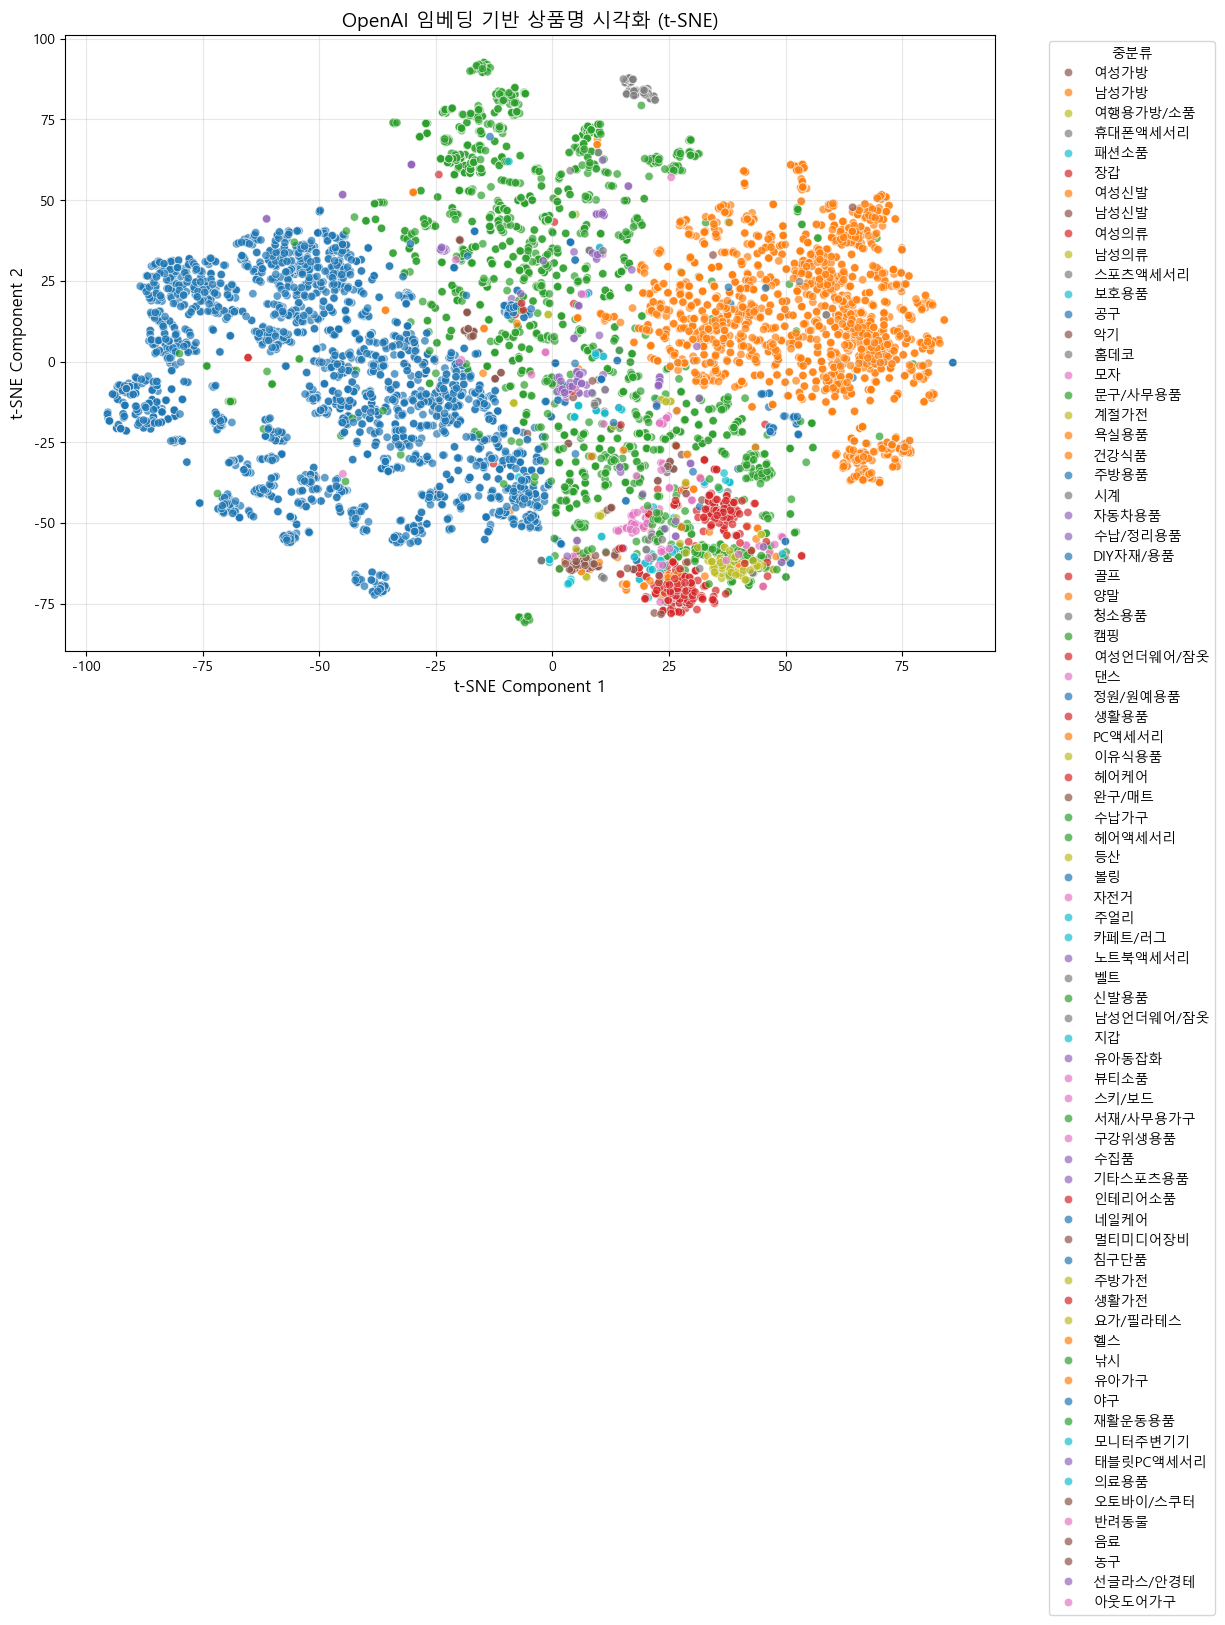

In [64]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings


# OpenAI 임베딩 모델 + t-SNE를 활용한 차원 축소 + 실루엣 계수 계산
# ✅ 환경 변수 로드

load_dotenv()
API_KEY = os.getenv('OPENAI_API_KEY')

# ✅ 엑셀 파일 로드
file_path = "db/오너클랜_클러스터링_0203.xlsx"
df = pd.read_excel(file_path)

# ✅ '카테고리명'에서 중분류 추출
df['중분류'] = df['카테고리명'].str.split('>').str[1]

# ✅ 카테고리별 색상 매핑
category_counts = df['중분류'].value_counts()
unique_categories = category_counts.index
palette = sns.color_palette("tab10", len(unique_categories))
category_colors = {category: palette[i] for i, category in enumerate(unique_categories)}
df['색상'] = df['중분류'].map(category_colors)

# ✅ 한글 폰트 설정 (Windows: Malgun Gothic, macOS: AppleGothic)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# ✅ OpenAI 임베딩 객체 생성
embeddings_model = OpenAIEmbeddings(model="text-embedding-ada-002", openai_api_key=API_KEY)

# ✅ 원본상품명 벡터화 함수
def get_embedding(text):
    """
    OpenAI의 text-embedding-ada-002 모델을 이용하여 텍스트를 벡터화합니다.
    벡터는 1536차원의 고유한 수치 표현으로 변환되며, 이를 활용하여 상품명 간의 의미적 유사성을 분석할 수 있습니다.
    """
    return embeddings_model.embed_documents(text)

# ✅ 여러 개의 텍스트를 한 번에 임베딩
df['embedding'] = get_embedding(df['원본상품명'].dropna().tolist())

# ✅ 임베딩 벡터를 NumPy 배열로 변환
embeddings_matrix = np.array(df['embedding'].tolist())

# ✅ t-SNE를 활용한 차원 축소 (2D 시각화)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
df[['TSNE1', 'TSNE2']] = tsne.fit_transform(embeddings_matrix)

# ✅ 시각화 - 같은 카테고리끼리 모이는지 확인
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='중분류', palette=category_colors, alpha=0.7)

# ✅ 그래프 설정
plt.title("OpenAI 임베딩 기반 상품명 시각화 (t-SNE)", fontsize=14)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="중분류", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(alpha=0.3)
plt.show()


📊 평균 실루엣 계수: -0.5029


C:\Users\sylee\AppData\Local\Temp\ipykernel_36664\3382170875.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df['중분류'], y=df['Silhouette'], palette="viridis")


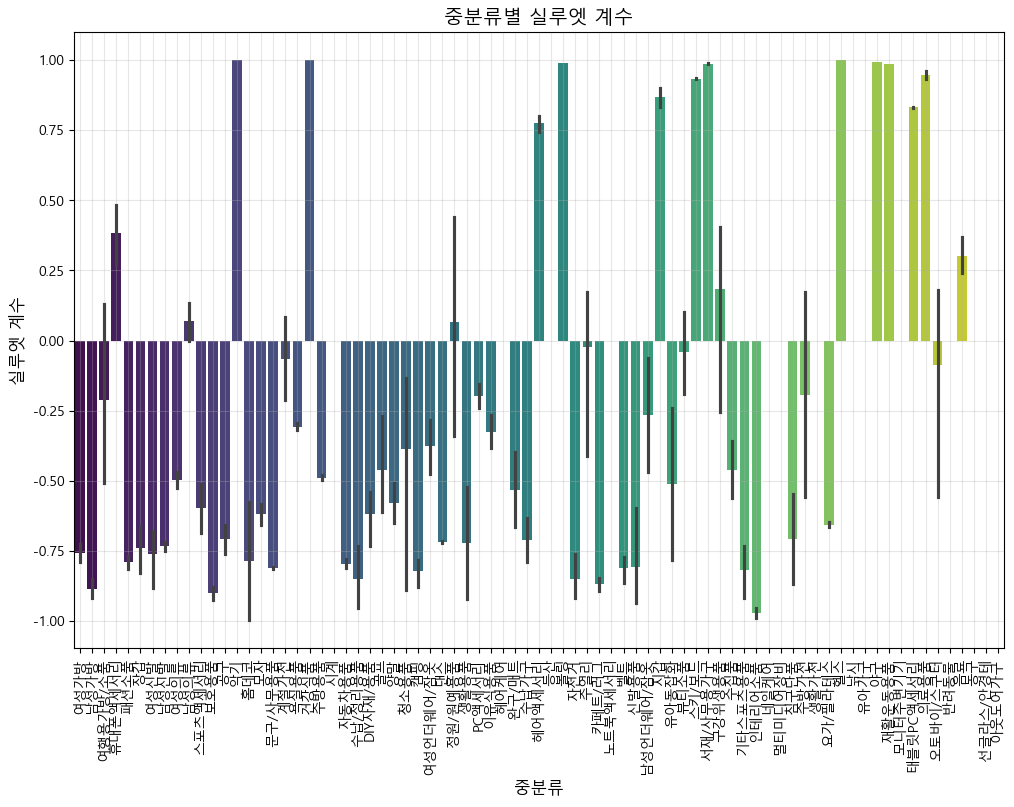

In [65]:
from sklearn.metrics import silhouette_samples, silhouette_score


# ✅ 실루엣 계수 계산
silhouette_avg = silhouette_score(df[['TSNE1', 'TSNE2']], df['중분류'].factorize()[0])  # 중분류 기준으로 계산
df['Silhouette'] = silhouette_samples(df[['TSNE1', 'TSNE2']], df['중분류'].factorize()[0])

print(f"📊 평균 실루엣 계수: {silhouette_avg:.4f}")

# ✅ 시각화 - 실루엣 계수 분포
plt.figure(figsize=(12, 8))
sns.barplot(x=df['중분류'], y=df['Silhouette'], palette="viridis")
plt.xticks(rotation=90)  # X축 라벨 회전
plt.title("중분류별 실루엣 계수", fontsize=14)
plt.xlabel("중분류", fontsize=12)
plt.ylabel("실루엣 계수", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


In [66]:
# ✅ "악기" 관련 상품 필터링
instrument_categories = df[df['중분류'].str.contains("악기", na=False, case=False)]  # "악기" 포함된 중분류만 선택

# ✅ 중분류별 개수 계산
instrument_counts = instrument_categories['중분류'].value_counts()

# ✅ 결과 출력
print(instrument_counts)

중분류
악기    2
Name: count, dtype: int64
